In [3]:
import sys
import importlib

import numpy as np
import pandas as pd
import xarray as xr
import pvlib as pv
import matplotlib.pyplot as plt

In [39]:
%matplotlib inline

In [5]:
sys.path.append('/home/travis/python_code/letkf_forecasting/')
import letkf_forecasting as lf

In [15]:
importlib.reload(lf)

<module 'letkf_forecasting' from '/home/travis/python_code/letkf_forecasting/letkf_forecasting.py'>

In [6]:
#for Golem
sat_14 = xr.open_dataset('/home/travis/python_code/forecasting/current_data/sat_14.nc')
sat_15 = xr.open_dataset('/home/travis/python_code/forecasting/current_data/sat_15.nc')
wind_15 = xr.open_dataset('/home/travis/python_code/forecasting/current_data/wind_15_crop.nc')
sensor_data = pd.read_hdf('/home/travis/python_code/forecasting/current_data/sensor_data.h5')
sensor_loc = pd.read_hdf('/home/travis/python_code/forecasting/current_data/sensor_loc.h5')

In [7]:
clear_sky_good = xr.DataArray(
    data=sat_15.GHI.values/sat_14.GHI.values,
    coords=sat_15.coords)

sat_15['clear_sky_good'] = clear_sky_good

In [8]:
sensor_CI = sensor_data[['clearsky_index', 'id']]
sensor_CI = sensor_CI.reset_index().pivot(
    index='time', columns='id', values='clearsky_index')
sensor_CI = sensor_CI.resample('5min').mean().dropna() ##Use scipy interpolate instead of this.

In [111]:
#This is taken from http://www.groundcontrol.com/Satellite_Look_Angle_Calculator.html
goes15_azimuth = 220.5*(2*np.pi)/360
goes15_elevation = 44.1*(2*np.pi)/360

time = pd.Timestamp('2014-04-15 11:00:00').tz_localize('MST')
tus = pv.location.Location(32.2, -111, 'US/Arizona', 700,'Tucson')
solar_position = tus.get_solarposition(time)
lf.parallax_shift(2000,
                     goes15_azimuth,
                     goes15_elevation,
                     solar_position['azimuth'].values*np.pi/360,
                     solar_position['elevation'].values*np.pi/360)

(array([ 4502.7974688]), array([ 2902.55179225]))

In [182]:
wind_15.U.max()

<xarray.DataArray 'U' ()>
array(33.96928787231445, dtype=float32)

In [183]:
wind_15.V.max()

<xarray.DataArray 'V' ()>
array(2.541465997695923, dtype=float32)

0.129006870048
0.129009016766


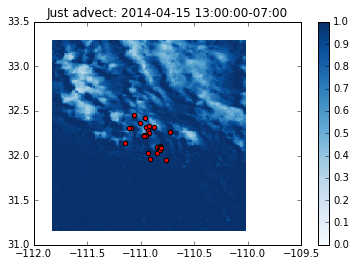

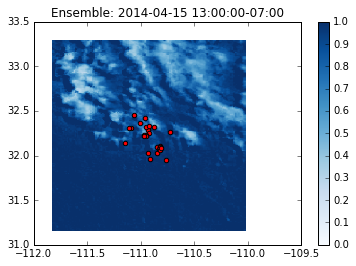

0.128841033073
0.127952782501


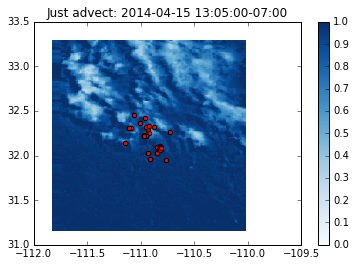

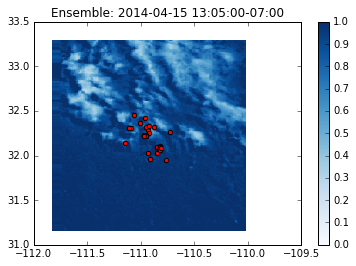

0.231128986527
0.21810983755


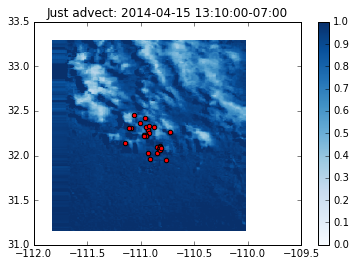

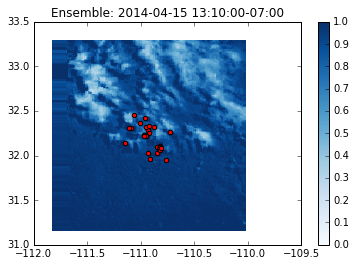

0.17676835805
0.146402038925


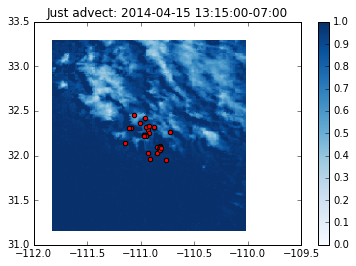

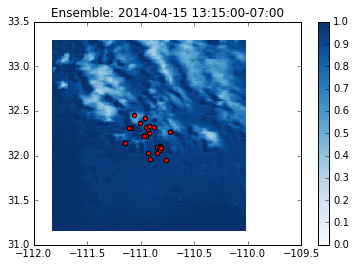

In [ ]:
importlib.reload(lf)
dx = 250 #in km
dy = 250 #in km
C_max = 1.2
assimilation_grid_size = 25
localization = 30

sat_sig = .01
sensor_sig = .1
ens_size = 40
wind_sigma = (.4, .05)
wind_size = 2
CI_sigma = .03

start_time = '2014-04-15 13:00:00' #11:00:00 is not a bad start
end_time = '2014-04-15 13:30:00' #Gets boring shortly after 14:00:00

lf.simulation(sat=sat_15, wind=wind_15, sensor_data=sensor_CI,
              sensor_loc=sensor_loc,
              start_time=start_time, end_time=end_time, dx=dx, dy=dy,
              C_max=C_max,
              assimilation_grid_size=assimilation_grid_size,
              localization_length=localization,
              sat_sig=sat_sig, sensor_sig=sensor_sig, ens_size=ens_size,
              wind_sigma=wind_sigma, wind_size=wind_size, CI_sigma=CI_sigma)

In [248]:
# Better Crop
long_min = sensor_loc['lon'].min()
long_max = sensor_loc['lon'].max()
lat_min = sensor_loc['lat'].min()
lat_max = sensor_loc['lat'].max()
long = sat_15.long.values
lat = sat_15.lat.values
min_x = abs(long[0, :] - long_min).argmin()
max_x = abs(long[0, :] - long_max).argmin()
min_y = abs(lat[:, 0] - lat_min).argmin()
max_y = abs(lat[:, 0] - lat_max).argmin()

U_max = wind_15.U.max() # know U is positive
V_max = abs(wind_15.V.min()) # know V is negative

left = int(U_max*60*30/250) + 20
right = 20

up = int(V_max*60*30/250) + 20
down = 20

x_crop = slice(min_x - left, max_x + right)
y_crop = slice(min_y - down, max_y + up)
print('X length: ' + 
      str(max_x + right - (min_x - left)))
print('Y length: ' + 
      str(max_y + up - (min_y - down)))

X length: 469
Y length: 330


In [256]:
sat_15.long[0, :]

<xarray.DataArray 'long' (y: 804)>
array([-111.82381864, -111.82157033, -111.81932203, -111.81707372,
       -111.81482542, -111.81257711, -111.81032881, -111.8080805 ,
       -111.8058322 , -111.80358389, -111.80133559, -111.79908728,
       -111.79683898, -111.79459067, -111.79234237, -111.79009406,
       -111.78784576, -111.78559745, -111.78334915, -111.78110084,
       -111.77885254, -111.77660423, -111.77435593, -111.77210762,
       -111.76985932, -111.76761101, -111.76536271, -111.7631144 ,
       -111.7608661 , -111.75861779, -111.75636949, -111.75412118,
       -111.75187288, -111.74962457, -111.74737627, -111.74512796,
       -111.74287966, -111.74063135, -111.73838305, -111.73613474,
       -111.73388644, -111.73163813, -111.72938983, -111.72714152,
       -111.72489322, -111.72264491, -111.72039661, -111.7181483 ,
       -111.7159    , -111.71365169, -111.71140339, -111.70915508,
       -111.70690678, -111.70465847, -111.70241017, -111.70016186,
       -111.69791356, -111.

0.129006870048
0.129488402075


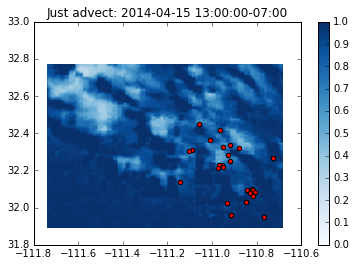

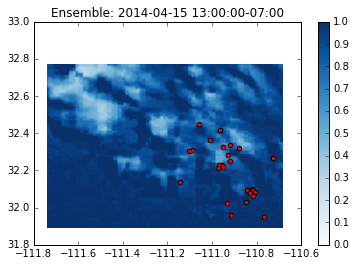

0.129937229845
0.118047857504


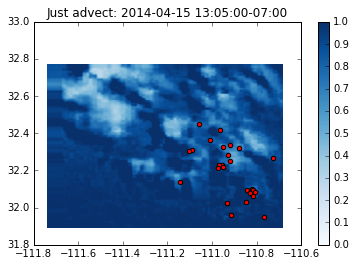

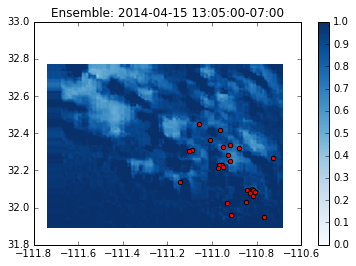

0.243803765258
0.226536476804


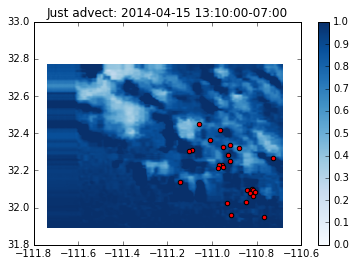

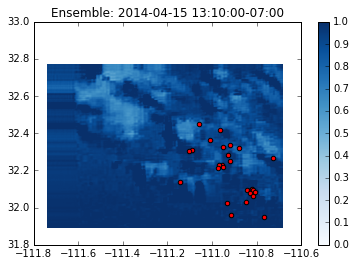

In [ ]:
importlib.reload(lf)
dx = 250 #in km
dy = 250 #in km
C_max = 1.2
assimilation_grid_size = 25
localization = 30

sat_sig = 0.1 #0.01
sensor_sig = 0.01 #0.1
ens_size = 20
wind_sigma = (.4, .05)
wind_size = 2
CI_sigma = .1

start_time = '2014-04-15 13:00:00' #11:00:00 is not a bad start
end_time = '2014-04-15 13:30:00' #Gets boring shortly after 14:00:00

x_crop_stag = slice(x_crop.start - 1, x_crop.stop)
y_crop_stag = slice(y_crop.start - 1, y_crop.stop)

lf.simulation(sat=sat_15.isel(y=x_crop, x=y_crop),
              wind=wind_15.isel(west_east=x_crop, west_east_stag=x_crop_stag,
                                south_north=y_crop, south_north_stag=y_crop_stag),
              sensor_data=sensor_CI,
              sensor_loc=sensor_loc,
              start_time=start_time, end_time=end_time, dx=dx, dy=dy,
              C_max=C_max,
              assimilation_grid_size=assimilation_grid_size,
              localization_length=localization,
              sat_sig=sat_sig, sensor_sig=sensor_sig, ens_size=ens_size,
              wind_sigma=wind_sigma, wind_size=wind_size, CI_sigma=CI_sigma)